<a href="https://colab.research.google.com/github/abdulrahman-alameri/Catal/blob/main/notebook_yolo_gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Détection de Nanoparticles avec YOLOv8 + Gemini AI
## Pipeline complet d'analyse avec LLM

Ce notebook combine:
- **YOLOv8** (détection multi-modèles avec fusion Soft-NMS)
- **Gemini AI** (analyse intelligente et génération de rapports)
- **Visualisation** (graphiques et images annotées)

## ✅ Étape 1 : Installation des dépendances

In [1]:
# Installation
!pip install -q ultralytics opencv-python ensemble_boxes google-generativeai pillow pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00


## 🔑 Étape 2 : Configuration Gemini API

### Instructions:
1. Allez sur https://ai.google.dev/
2. Cliquez "Get API key" → "Create API key"
3. Copiez votre clé
4. Dans Colab: Cliquez 🔑 (Secrets) → Add new secret
5. Name: `GOOGLE_API_KEY` | Value: `votre_cle`
6. Grant notebook access: ✓

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
from ensemble_boxes import soft_nms
import google.generativeai as genai
from google.colab import userdata, files
import json
from datetime import datetime
from PIL import Image

print("✅ Importations réussies")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Importations réussies


In [3]:
# Configuration Gemini API
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✅ API Gemini configurée avec succès")
    print(f"Clé API (masquée): ...{GOOGLE_API_KEY[-10:]}")
except Exception as e:
    print(f"❌ Erreur: {e}")
    print("Assurez-vous d'avoir ajouté GOOGLE_API_KEY aux secrets (🔑)")

✅ API Gemini configurée avec succès
Clé API (masquée): ...AotLvJi3no


## 📁 Étape 3 : Monter Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté")

Mounted at /content/drive
✅ Google Drive monté


## 🔧 Étape 4 : Charger les modèles YOLOv8

In [5]:
print("📥 Chargement des modèles YOLOv8...")
model_N = YOLO('yolov8n.pt')
model_S = YOLO('yolov8s.pt')
model_M = YOLO('yolov8m.pt')
print("✅ Modèles chargés avec succès")

# Dictionnaires de classes
class_colors = {
    0: (0, 0, 255),        # LCN - Red
    1: (0, 255, 0),        # MCV - Green
    2: (243, 243, 0),      # TMCV - Yellow
    3: (0, 223, 183),      # V - Cyan
    4: (255, 0, 0)         # Scale bar - Blue
}

class_labels = {
    0: "LCN",
    1: "MCV",
    2: "TMCV",
    3: "V",
    4: "Scale Bar"
}

print("📊 Classes définies:", class_labels)

📥 Chargement des modèles YOLOv8...
✅ Modèles chargés avec succès
📊 Classes définies: {0: 'LCN', 1: 'MCV', 2: 'TMCV', 3: 'V', 4: 'Scale Bar'}


## 🔍 Étape 5 : Fonctions de détection et fusion

In [6]:
def extract_boxes_confidences_labels(results):
    """Extrait boîtes, scores et labels"""
    boxes, scores, labels = [], [], []
    for r in results[0].boxes.data:
        x1, y1, x2, y2, conf, cls = r.tolist()
        boxes.append([x1, y1, x2, y2])
        scores.append(conf)
        labels.append(int(cls))
    return boxes, scores, labels

def normalize_boxes(boxes, width, height):
    """Normalise les boîtes (0-1)"""
    return [[x1/width, y1/height, x2/width, y2/height] for x1, y1, x2, y2 in boxes]

def denormalize_box(box, width, height):
    """Dénormalise les boîtes"""
    x1, y1, x2, y2 = box
    return [int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)]

def perform_yolo_detection(image_path, models):
    """Détection avec fusion Soft-NMS"""
    print(f"🔍 Détection pour {os.path.basename(image_path)}...")

    # Détections individuelles
    results_N = models[0](image_path, save=False, verbose=False)
    results_S = models[1](image_path, save=False, verbose=False)
    results_M = models[2](image_path, save=False, verbose=False)

    # Extraction
    boxes_N, scores_N, labels_N = extract_boxes_confidences_labels(results_N)
    boxes_S, scores_S, labels_S = extract_boxes_confidences_labels(results_S)
    boxes_M, scores_M, labels_M = extract_boxes_confidences_labels(results_M)

    # Normalisation
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    boxes_N = normalize_boxes(boxes_N, width, height)
    boxes_S = normalize_boxes(boxes_S, width, height)
    boxes_M = normalize_boxes(boxes_M, width, height)

    # Fusion
    if any(len(sublist) > 0 for sublist in [boxes_N, boxes_S, boxes_M]):
        boxes_fused, scores_fused, labels_fused = soft_nms(
            [boxes_N, boxes_S, boxes_M],
            [scores_N, scores_S, scores_M],
            [labels_N, labels_S, labels_M],
            iou_thr=0.3, sigma=0.5, thresh=0.5
        )
    else:
        boxes_fused, scores_fused, labels_fused = [], [], []

    print(f"✅ {len(boxes_fused)} objets détectés")

    return {
        'image_path': image_path,
        'image_size': (height, width),
        'boxes_fused': boxes_fused,
        'scores_fused': scores_fused,
        'labels_fused': labels_fused,
        'image': image
    }

print("✅ Fonctions définies")

✅ Fonctions définies


## 🤖 Étape 6 : Analyse avec Gemini AI

In [30]:
def get_gemini_model():
    """Retourne le modèle Gemini"""
    return genai.GenerativeModel('gemini-1.5-flash')

def analyze_with_gemini(detection_data, class_labels):
    """Analyse avec Gemini AI"""
    print("🤖 Analyse Gemini en cours...")

    model = get_gemini_model()

    # Préparation
    total = len(detection_data['labels_fused'])
    classes_dist = dict(Counter(detection_data['labels_fused']))
    avg_conf = float(np.mean(detection_data['scores_fused'])) if detection_data['scores_fused'] else 0

    prompt = f"""
    Vous êtes expert en microscopie et analyse de nanoparticules.

    Analysez ces résultats de détection YOLOv8:
    - Objets détectés: {total}
    - Distribution: {classes_dist}
    - Confiance moyenne: {avg_conf:.1%}
    - Confiance min/max: {min(detection_data['scores_fused']):.1%} / {max(detection_data['scores_fused']):.1%}

    Fournissez (en français, concis):
    1. Qualité de détection (Excellente/Bonne/Acceptable/Faible)
    2. Objets principaux détectés
    3. Anomalies observées
    4. Score de confiance global (0-100)
    5. 1-2 recommandations d'amélioration
    """

    response = model.generate_content(prompt)
    print("✅ Analyse complétée")
    return response.text

print("✅ Fonction d'analyse Gemini définie")

✅ Fonction d'analyse Gemini définie


## 📊 Étape 7 : Visualisation

In [44]:
def draw_detections(detection_data, class_colors, class_labels):
    """Dessine les détections sur l'image"""
    image = detection_data['image'].copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    for i in range(len(detection_data['boxes_fused'])):
        box = denormalize_box(detection_data['boxes_fused'][i], width, height)
        score = detection_data['scores_fused'][i]
        label = detection_data['labels_fused'][i]

        color = class_colors.get(label, (255, 255, 255))
        label_name = class_labels.get(label, f"Class {label}")

        # Rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Texte
        text = f"{label_name} {score:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
        )

        text_color = (0, 0, 0) if color == (243, 243, 0) else (255, 255, 255)
        cv2.rectangle(
            image,
            (box[0], box[1] - text_height - baseline),
            (box[0] + text_width, box[1]),
            color, -1
        )
        cv2.putText(
            image, text, (box[0], box[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2
        )

    return image

def show_results(detection_data, class_colors, class_labels):
    """Affiche les résultats"""

    # Image annotée
    image_annotated = draw_detections(detection_data, class_colors, class_labels)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Afficher l'image
    ax1.imshow(image_annotated)
    ax1.set_title("Détections YOLOv8 fusionnées", fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Histogramme des classes
    if len(detection_data['labels_fused']) > 0:  # ← C'EST LA CLÉ
        class_counts = Counter(detection_data['labels_fused'])
        colors_list = [np.array(class_colors.get(c, (128, 128, 128))) / 255
                      for c in class_counts.keys()]

        ax2.bar([class_labels.get(c, f"Class {c}") for c in class_counts.keys()],
                class_counts.values(), color=colors_list, edgecolor='black', linewidth=1.5)
        ax2.set_xlabel("Classes", fontsize=12)
        ax2.set_ylabel("Nombre de détections", fontsize=12)
        ax2.set_title("Distribution des classes", fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Aucun objet détecté', ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()
    return image_annotated

## 🚀 Étape 8 : Exécuter l'analyse

In [45]:
# Chemin de l'image (À MODIFIER selon votre dossier)
image_path = "/content/drive/MyDrive/CATAL/data/annotation_nano/test/images/59.jpg"

# Vérifier l'existence
if os.path.exists(image_path):
    print(f"✅ Image trouvée: {image_path}")
else:
    print(f"❌ Image non trouvée: {image_path}")
    print("📂 Veuillez modifier le chemin ci-dessus")

✅ Image trouvée: /content/drive/MyDrive/CATAL/data/annotation_nano/test/images/59.jpg


In [46]:
# Étape 1: Détection
print("=" * 60)
print("🔬 ANALYSE DE NANOPARTICULES AVEC YOLO + GEMINI")
print("=" * 60)

models = [model_N, model_S, model_M]
detection_data = perform_yolo_detection(image_path, models)

if not len(detection_data['labels_fused']):
    print("❌ Aucun objet détecté")
else:
    # Étape 2: Afficher les résultats bruts
    print(f"\n📊 Détails des détections:")
    for i in range(len(detection_data['boxes_fused'])):
        label = detection_data['labels_fused'][i]
        score = detection_data['scores_fused'][i]
        label_name = class_labels.get(label, f"Class {label}")
        print(f"  {i+1}. {label_name}: {score:.2%}")

🔬 ANALYSE DE NANOPARTICULES AVEC YOLO + GEMINI
🔍 Détection pour 59.jpg...
✅ 7 objets détectés

📊 Détails des détections:
  1. Class 54: 73.03%
  2. Class 54: 63.91%
  3. Class 54: 60.22%
  4. Class 54: 58.02%
  5. Class 54: 54.63%
  6. Class 54: 53.92%
  7. Class 54: 52.07%


In [56]:
if len(detection_data['scores_fused']) > 0:
    average_confidence = float(np.mean(detection_data['scores_fused']))
else:
    average_confidence = 0.0


📸 Génération des visualisations...


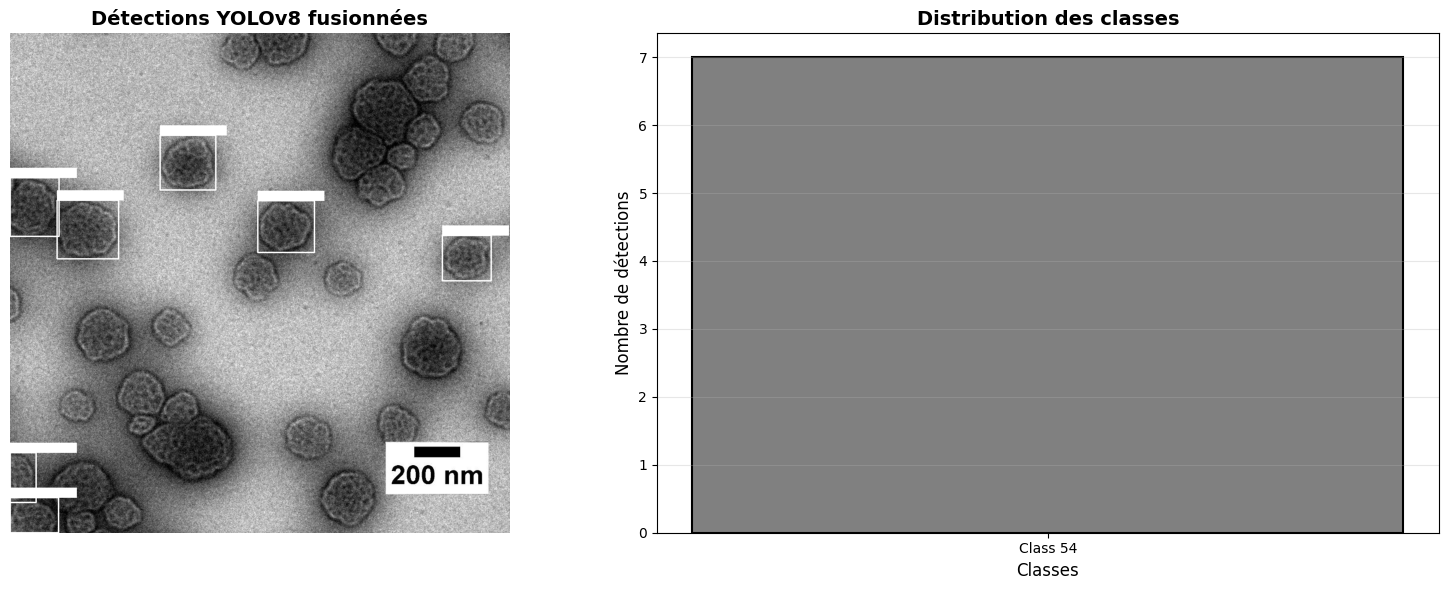

✅ Image sauvegardée: /content/detection_results.png


In [57]:
# Étape 4: Visualiser
if len(detection_data['labels_fused']) > 0:
    print("\n📸 Génération des visualisations...")
    image_annotated = show_results(detection_data, class_colors, class_labels)

    # Sauvegarder
    output_path = '/content/detection_results.png'
    cv2.imwrite(output_path, cv2.cvtColor(image_annotated, cv2.COLOR_RGB2BGR))
    print(f"✅ Image sauvegardée: {output_path}")

## 💬 Étape 9 : Chat interactif avec Gemini (BONUS)

In [58]:
def interactive_chat(detection_data, class_labels, max_turns=3):
    """Chat simple avec Gemini"""

    model = get_gemini_model()

    context = f"""
    Vous êtes expert en microscopie de nanoparticules.
    Résultats actuels:
    - {len(detection_data['labels_fused'])} objets détectés
    - Distribution: {dict(Counter(detection_data['labels_fused']))}
    - Confiance: {np.mean(detection_data['scores_fused']):.1%}

    Répondez brièvement en français.
    """

    print("\n🎤 Chat interactif - Posez vos questions sur l'analyse")
    print(f"(Tapez 'exit' pour quitter)\n")

    for turn in range(max_turns):
        question = input(f"❓ Question {turn+1}: ").strip()

        if question.lower() == 'exit':
            print("👋 Chat terminé")
            break

        if not question:
            continue

        prompt = f"{context}\nQuestion: {question}"
        response = model.generate_content(prompt)

        print(f"\n🤖 Réponse: {response.text}\n")

# À décommenter pour utiliser:
# interactive_chat(detection_data, class_labels, max_turns=3)

## 📥 Étape 10 : Télécharger les résultats

In [61]:
# Sauvegarder les résultats
results = {
    'timestamp': datetime.now().isoformat(),
    'total_detections': len(detection_data['labels_fused']),
    'average_confidence': average_confidence,  # ← La variable pré-calculée
    'class_distribution': {int(k): int(v) for k, v in
     Counter(detection_data['labels_fused']).items()},
    'analysis': analysis if 'analysis' in locals() else None
}

# Sauvegarder en JSON
with open('nanoparticle_analysis_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("✅ Résultats sauvegardés")
print("\n📊 Résumé:")
print(json.dumps(results, indent=2, ensure_ascii=False))

✅ Résultats sauvegardés

📊 Résumé:
{
  "timestamp": "2025-12-03T15:04:03.018514",
  "total_detections": 7,
  "average_confidence": 0.5940179313932147,
  "class_distribution": {
    "54": 7
  },
  "analysis": null
}


In [62]:
# Télécharger les fichiers
print("\n📥 Téléchargement des fichiers...")

files_to_download = [
    '/content/detection_results.png',
    '/content/nanoparticle_analysis_results.json'
]

for file_path in files_to_download:
    if os.path.exists(file_path):
        print(f"Téléchargement: {file_path}")
        # files.download(file_path)  # Décommenter pour télécharger

print("✅ Prêt à télécharger!")


📥 Téléchargement des fichiers...
Téléchargement: /content/detection_results.png
Téléchargement: /content/nanoparticle_analysis_results.json
✅ Prêt à télécharger!


## 🎯 Prochaines étapes

1. **Traiter plusieurs images**: Créer une boucle sur un dossier
2. **Générer un rapport PDF**: Ajouter une étape de conversion Markdown → PDF
3. **Sauvegarder en base de données**: Utiliser Google Sheets ou une DB
4. **Créer un dashboard**: Utiliser Streamlit pour visualisation
5. **Fine-tuning du modèle**: Entraîner YOLOv8 sur vos données

### 📚 Ressources
- [Documentation Gemini](https://ai.google.dev/)
- [YOLOv8 Documentation](https://docs.ultralytics.com/)
- [Ensemble Boxes](https://github.com/ZFTurbo/Weighted-Boxes-Fusion)